In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv')

lista_preco = list(df['PriceUSD'].values)
lista_preco.pop(0)
lista_preco.append(0)
df['preco_dia_seguinte'] = lista_preco

# Apagar nulos na coluna PriceUSD
lista_apagar = list(df.loc[df['PriceUSD'].isna()].index)
df.drop(lista_apagar, inplace = True)

# Apagar nulos na coluna preco_dia_seguinte
lista_apagar = list(df.loc[df['preco_dia_seguinte'].isna()].index)
df.drop(lista_apagar, inplace = True)

# Apagar todas colunas com mais de 1 valor nulo
null_counts = df.isnull().sum()
colunas_apagar = null_counts[null_counts > 1].index.tolist()
df.drop(colunas_apagar, axis = 1, inplace  = True)

# Criar as colunas de data
df['time'] = pd.to_datetime(df['time'])
df['ano'] = df['time'].dt.year
df['mes'] = df['time'].dt.month
df['dia'] = df['time'].dt.day
df['dia_semana'] =df['time'].dt.day_of_week
df['dia_ano'] =df['time'].dt.day_of_year
datas = df[['time']].copy(deep=True)
datas['time_'] = datas['time']
df.drop(['time'], axis = 1, inplace  = True)

# Apagar as colunas com pouca correlação ao preco_dia_seguinte
colunas_interesse = ['mes', 'dia', 'dia_semana', 'dia_ano', 'PriceUSD']
correlation_matrix = df.corr()['preco_dia_seguinte']
colunas_remover = correlation_matrix[(correlation_matrix >= -0.3) & (correlation_matrix <= 0.3)].index.tolist()
colunas_remover = [coluna for coluna in colunas_remover if coluna not in colunas_interesse]
df.drop(colunas_remover, axis=1, inplace = True)

df.dropna(inplace=True)

C:\Users\Cliente\AppData\Local\Temp\ipykernel_2560\460244501.py:1: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv')


In [3]:
X = df.drop(['preco_dia_seguinte'], axis = 1)
y = df[['preco_dia_seguinte']]

scale_X = MinMaxScaler()
X = scale_X.fit_transform(X)

scale_y = MinMaxScaler()
y = scale_y.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X,y, shuffle=True, test_size=0.30, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, shuffle=True, test_size=0.5, random_state=50)


X_train_data, X_temp_data, y_train_data, y_temp_data = train_test_split(datas['time'],datas['time_'], shuffle=True, test_size=0.30, random_state=50)
X_test_data, X_val_data, y_test_data, y_val_data = train_test_split(X_temp_data, y_temp_data, shuffle=True, test_size=0.5, random_state=50)

In [4]:
input_dim = X.shape[1]

# Criar um modelo sequencial
model = Sequential()

# Adicionar a primeira camada densa com 64 unidades, função de ativação relu
model.add(Dense(64, input_dim=input_dim, activation='relu'))
# Adicionar uma segunda camada densa com 32 unidades, função de ativação relu
model.add(Dense(32, activation='relu'))
# Adicionar a camada de saída com 1 unidade, função de ativação linear
model.add(Dense(1, activation='linear'))
# Compilar o modelo com o otimizador adam e a função de perda mean_squared_error
model.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
# Ajustar o modelo aos dados de treinamento
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose = 0)

In [6]:
predict = model.predict(X_test)
# Desnormaliza o y_test na variável y_desnormalizado
y_test_desnormalizado = scale_y.inverse_transform(y_test)

# Desnormaliza o predict na variável predict_desnormalizado
predict_desnormalizado = scale_y.inverse_transform(predict)

23/23 [==============================] - 0s 2ms/step


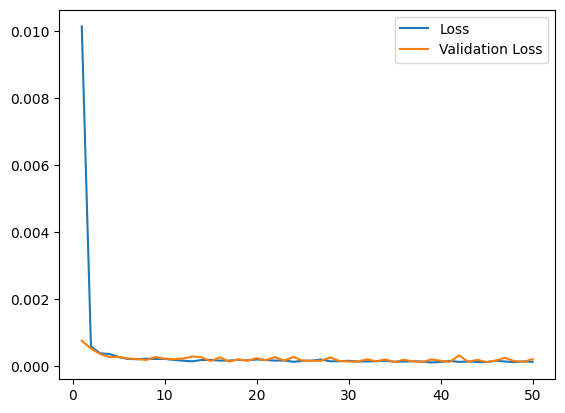

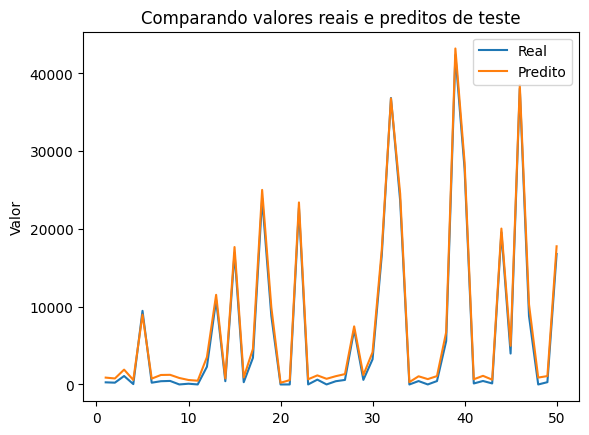

In [7]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss'] 

# Definimos os valores do eixo x (as épocas)
x = [y+1 for y in range(0,len(loss_history))]

plt.plot(x, loss_history, label = "Loss")
plt.plot(x, val_loss_history, label = "Validation Loss")
plt.legend()
plt.show()


grafico_x = [x for x in range(1,len(y_test_desnormalizado[:50])+1)]
plt.plot(grafico_x, y_test_desnormalizado[:50], label='Real')
plt.plot(grafico_x, predict_desnormalizado[:50], label='Predito')
plt.title('Comparando valores reais e preditos de teste')
plt.legend()
plt.ylabel('Valor')
plt.show()

In [8]:
# Calcula o mse com a biblioteca do sklearn
mse = mean_squared_error(y_test_desnormalizado, predict_desnormalizado)
print("Mean squared error Regressão Linear: ", mse)

Mean squared error Regressão Linear:  920933.7042680804


In [9]:
df_predito = pd.DataFrame()
df_predito['Data'] = X_test_data
df_predito['Real'] = list(y_test_desnormalizado.flatten())
df_predito['Predito'] = list(predict_desnormalizado.flatten())
df_predito.sort_values(by='Real', inplace=True)

In [12]:
df_predito

,Data,Real,Predito
1450,2012-12-23,0.050541,623.029724
567,2010-07-24,0.056000,520.159485
2792,2016-08-26,0.060000,134.719406
575,2010-08-01,0.060012,-73.154243
3529,2018-09-02,0.060593,425.248260
...,...,...,...
910,2011-07-02,59749.473823,57204.355469
2214,2015-01-26,59905.618470,60022.550781
4510,2021-05-10,59932.930647,58856.968750
2926,2017-01-07,60280.876176,58931.488281


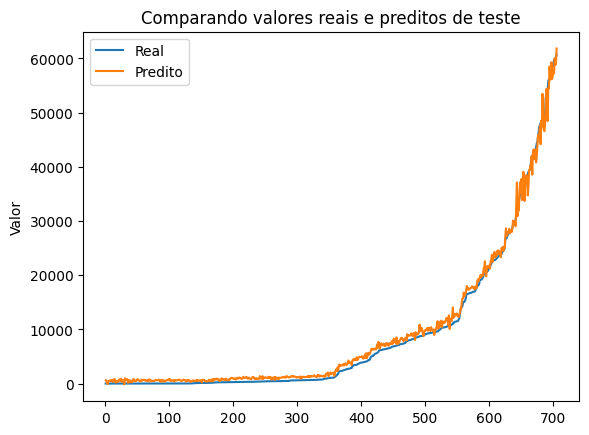

In [11]:
grafico_x = [x for x in range(1,len(df_predito)+1)]
plt.plot(grafico_x, df_predito.Real, label='Real')
plt.plot(grafico_x, df_predito.Predito, label='Predito')
plt.title('Comparando valores reais e preditos de teste')
plt.legend()
plt.ylabel('Valor')
plt.show()